# End-to-End ML Pipeline with Scikit-learn Pipeline API

Build a reusable and production-ready machine learning pipeline for predicting customer churn.

## Downloading the dataset with pandas

In [1]:
import pandas as pd

base_path = "hf://datasets/aai510-group1/telco-customer-churn/"

splits = {
    "train": "train.csv",
    "validation": "validation.csv",
    "test": "test.csv"
}

# Load all splits
dfs = {
    split: pd.read_csv(base_path + file)
    for split, file in splits.items()
}

# Combine into a single DataFrame
ds = pd.concat(dfs.values(), axis=0, ignore_index=True)

## print the dataset

In [14]:
ds.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,Country,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,Churn
0,72,4,19.44,NaN,NaN,51,San Mateo,4849,Two Year,United States,...,25,2191.15,0,486.00,0.0,2677.15,0,1,94403,0
1,27,59,45.62,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,United States,...,35,3418.20,0,1596.70,0.0,5014.90,1,1,95685,0
2,59,0,16.07,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,United States,...,46,851.20,0,739.22,0.0,1590.42,0,0,95064,0
3,25,27,0.00,NaN,NaN,49,Brea,2068,One Year,United States,...,27,1246.40,30,0.00,0.0,1276.40,1,0,92823,0
4,31,21,17.22,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,United States,...,58,3563.80,0,998.76,0.0,4562.56,0,1,95117,1


## Creating pipeline for the preprocessor to later use

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Split features / target
X = ds.drop(columns=["Churn"])
y = ds["Churn"]

# Identify column types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

# Numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

## Making sure if numeric and text features are saparated into numeric and categorical

In [4]:
numeric_features, categorical_features

(Index(['Age', 'Avg Monthly GB Download', 'Avg Monthly Long Distance Charges',
        'Churn Score', 'CLTV', 'Dependents', 'Device Protection Plan',
        'Internet Service', 'Latitude', 'Longitude', 'Married',
        'Monthly Charge', 'Multiple Lines', 'Number of Dependents',
        'Number of Referrals', 'Online Backup', 'Online Security',
        'Paperless Billing', 'Partner', 'Phone Service', 'Population',
        'Premium Tech Support', 'Referred a Friend', 'Satisfaction Score',
        'Senior Citizen', 'Streaming Movies', 'Streaming Music', 'Streaming TV',
        'Tenure in Months', 'Total Charges', 'Total Extra Data Charges',
        'Total Long Distance Charges', 'Total Refunds', 'Total Revenue',
        'Under 30', 'Unlimited Data', 'Zip Code'],
       dtype='object'),
 Index(['Churn Category', 'Churn Reason', 'City', 'Contract', 'Country',
        'Customer ID', 'Customer Status', 'Gender', 'Internet Type', 'Lat Long',
        'Offer', 'Payment Method', 'Quarter', 'St

## Hyperparameters tuning and Training
- We use GridSearchCV for hyperparameter tuning on Logistics Regrssion
- We use CV to cross validate while tuning hyperparameters

NOTE: For that purpose we use GridSearchCV cause the dataset is small, if it is bigger than we use RandomSearchCV.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

logreg_param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

logreg_grid = logreg_grid.fit(X_train, y_train)

## Here we see which hyperparameters the GridSearchCV choose

In [6]:
logreg_grid.best_params_

{'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

## Let's print the graph for hyperparameter tuning

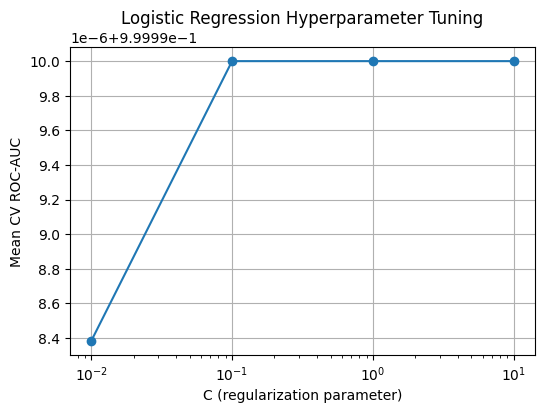

In [7]:
import matplotlib.pyplot as plt
import numpy as np

mean_test_scores = logreg_grid.cv_results_['mean_test_score']
param_C = [d['model__C'] for d in logreg_grid.cv_results_['params']]

plt.figure(figsize=(6,4))
plt.plot(param_C, mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel("C (regularization parameter)")
plt.ylabel("Mean CV ROC-AUC")
plt.title("Logistic Regression Hyperparameter Tuning")
plt.grid(True)
plt.show()

## Accuracy and loss of the model

In [8]:
best_logreg = logreg_grid.best_estimator_

In [9]:
from sklearn.metrics import accuracy_score

# Predict class labels
y_test_pred = best_logreg.predict(X_test)

# Compute accuracy
acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {acc:.4f}")

Test accuracy: 1.0000


In [10]:
from sklearn.metrics import log_loss

# Predict probabilities for the positive class
y_test_proba = best_logreg.predict_proba(X_test)

# Compute log loss
loss = log_loss(y_test, y_test_proba)
print(f"Test log loss: {loss:.4f}")


Test log loss: 0.0080


In [11]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_test_proba[:,1])
print(f"Test ROC-AUC: {roc_auc:.4f}")


Test ROC-AUC: 1.0000


## Save the pipeline with joblib

In [12]:
import joblib

# best_logreg is your trained pipeline from GridSearchCV
joblib.dump(best_logreg, "logreg_pipeline.pkl")
print("Pipeline saved successfully!")

Pipeline saved successfully!


## Loading the pipeline back to inference on it

In [13]:
# Load from file
loaded_pipeline = joblib.load("logreg_pipeline.pkl")

# Use it directly
y_pred = loaded_pipeline.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])